In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, label_binarize
import joblib
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from gensim.models import Word2Vec, KeyedVectors
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences, one_hot
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Disable warnings
warnings.filterwarnings('ignore')

In [35]:
# Download necessary resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
# Load the dataset
df = pd.read_csv("tripadvisor_hotel_reviews.csv")

In [37]:
# Analyze the dataset
print("Dataset Head:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nDataset Description:")
print(df.describe())

# Check for duplicates
duplicate_rows = df[df.duplicated()]
print(f"\nNumber of duplicate rows: {len(duplicate_rows)}")

# Check for null values
print("\nNull values count:")
print(df.isnull().sum())

print(f"\nDataset shape: {df.shape}")

Dataset Head:
                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB

Dataset Description:
             Rating
count  20491.000000
mean       3.952223
std        1.233030
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000

Number of duplicate rows: 0

Null values count:
Review    0
Rating    0
dtype: int64

Dataset shap

In [38]:
# Function to categorize sentiment
def categorize_sentiment(rating):
    if rating in [4, 5]:
        return 'Positive'
    elif rating==3:
        return 'Neutral'
    elif rating in [1, 2]:
        return 'Negative'

In [39]:
# Apply function to 'Rating' column and create new 'Sentiment' column
df['Sentiment'] = df['Rating'].apply(categorize_sentiment)
# Keep only review text and sentiment columns
df = df.loc[:, ['Review', 'Sentiment']]
print("\nDataset with sentiment:")
print(df.head())


Dataset with sentiment:
                                              Review Sentiment
0  nice hotel expensive parking got good deal sta...  Positive
1  ok nothing special charge diamond member hilto...  Negative
2  nice rooms not 4* experience hotel monaco seat...   Neutral
3  unique, great stay, wonderful time hotel monac...  Positive
4  great stay great stay, went seahawk game aweso...  Positive


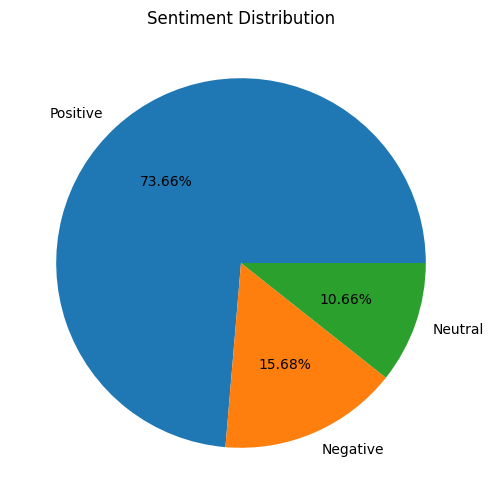

In [40]:
# Plot sentiment distribution
plt.figure(figsize=(8, 6))
df["Sentiment"].value_counts().plot(kind="pie", autopct="%0.2f%%")
plt.title("Sentiment Distribution")
plt.ylabel("")
plt.show()

In [41]:

# Prepare features and target
X = df.drop('Sentiment', axis=1)
y = df['Sentiment']

In [42]:
# Vocabulary size for one-hot encoding
voc_size = 10000

In [43]:
messages = X.copy()
messages.reset_index(inplace=True)

In [44]:
# Stopwords and Lemmatizer setup
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

def extract_words_with_pos(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()                     
    word_tokens = word_tokenize(text)       
    pos_tags = pos_tag(word_tokens)         
    
    words_with_pos = [(word, tag) for word, tag in pos_tags] 
    
    # Filter out stopwords and lemmatize
    lemmatized_text = [
        lemmatizer.lemmatize(word, get_pos(tag))
        for word, tag in pos_tags
        if word not in stop_words
    ]
    
    return words_with_pos, ' '.join(lemmatized_text) if lemmatized_text else ""

print("\nProcessing text data...")
words_with_pos_list = []
tokenized_corpus = []
for review in messages['Review']:
    words_with_pos, processed_review = extract_words_with_pos(review)
    words_with_pos_list.append(words_with_pos)
    tokenized_corpus.append(processed_review)


Processing text data...


In [45]:
# Encode sentiment labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"\nEncoded sentiment classes: {label_encoder.classes_}")


Encoded sentiment classes: ['Negative' 'Neutral' 'Positive']


# Load Google's pre-trained Word2Vec model
print("\nLoading Google's pre-trained Word2Vec model...")
try:
    # Attempt to load the model - you'll need to download this file first
    # File can be downloaded from: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
    word2vec_model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)
    print("Pre-trained Word2Vec model loaded successfully.")
except Exception as e:
    print(f"Error loading pre-trained model: {e}")
    print("Training a new Word2Vec model on the corpus instead...")
    # If pre-trained model isn't available, train a simple one on the corpus
    word2vec_model = Word2Vec(sentences=tokenized_corpus, vector_size=300, window=5, min_count=1, workers=4)
    word2vec_model = word2vec_model.wv
    print("New Word2Vec model trained successfully.")

# Get embedding dimension from the model
embedding_dim = word2vec_model.vector_size
print(f"Embedding dimension: {embedding_dim}")

# Set maximum sequence length
sent_length = 20

# Create embedding matrix for all words in vocabulary
def create_embedding_matrix(word2vec_model, tokenized_texts):
    # Get all unique words from the corpus
    all_words = set()
    for text in tokenized_texts:
        all_words.update(text)
    
    # Create word-to-index mapping
    word_to_index = {word: i+1 for i, word in enumerate(all_words)}  # Reserve 0 for padding
    
    # Create embedding matrix
    vocab_size = len(word_to_index) + 1  # +1 for padding token
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    # Fill the embedding matrix
    for word, idx in word_to_index.items():
        if word in word2vec_model:
            embedding_matrix[idx] = word2vec_model[word]
        else:
            # For words not in the model, use random initialization
            embedding_matrix[idx] = np.random.uniform(-0.25, 0.25, embedding_dim)
    
    return word_to_index, embedding_matrix, vocab_size

# Create embedding matrix
word_to_index, embedding_matrix, vocab_size = create_embedding_matrix(word2vec_model, tokenized_corpus)

# Convert texts to sequences
def texts_to_sequences(tokenized_texts, word_to_index, max_length):
    sequences = []
    for text in tokenized_texts:
        seq = [word_to_index.get(word, 0) for word in text]  # Get 0 if word not found
        sequences.append(seq)
    
    # Pad sequences
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='pre')
    return padded_sequences

# Convert corpus to sequences
print("\nConverting text to sequences using Word2Vec embeddings...")
embedded_docs = texts_to_sequences(tokenized_corpus, word_to_index, sent_length)
print(f"Embedded docs shape: {embedded_docs.shape}")

In [46]:
# Convert text to one-hot representations
print("\nConverting text to one-hot representations...")
onehot_repr = [one_hot(words, voc_size) for words in tokenized_corpus]


Converting text to one-hot representations...


In [47]:
# Pad sequences to same length
sent_length = 20
embedded_docs = pad_sequences(onehot_repr, padding='pre', maxlen=sent_length)
print(f"Embedded docs shape: {embedded_docs.shape}")

Embedded docs shape: (20491, 20)


In [48]:
# Convert to numpy arrays
X_final = np.array(embedded_docs)

In [49]:
# Convert target to one-hot encoding (for categorical_crossentropy)
num_classes = len(np.unique(y_encoded))
y_final = to_categorical(y_encoded, num_classes=num_classes)
print(f"Number of classes: {num_classes}")
print(f"X shape: {X_final.shape}, y shape: {y_final.shape}")

Number of classes: 3
X shape: (20491, 20), y shape: (20491, 3)


In [50]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)
print(f"Training shapes: X: {X_train.shape}, y: {y_train.shape}")
print(f"Testing shapes: X: {X_test.shape}, y: {y_test.shape}")

Training shapes: X: (13728, 20), y: (13728, 3)
Testing shapes: X: (6763, 20), y: (6763, 3)


In [51]:
# Define model parameters
embedded_vector_features = 100

In [52]:
# Build the model
print("\nBuilding LSTM model...")
model = Sequential()
model.add(Embedding(voc_size, embedded_vector_features, input_length=sent_length, trainable=True))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.build((None, sent_length))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True
)

# Train the model
print("\nTraining the model...")
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=20, 
    batch_size=64,
    callbacks=[early_stopping]
)


Building LSTM model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 20, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20, 64)         │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,054,755 (4.02 MB)

 Trainable params: 1,054,755 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

None

Training the model...
Epoch 1/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7350 - loss: 0.7841 - val_accuracy: 0.7764 - val_loss: 0.5927
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7999 - loss: 0.5233 - val_accuracy: 0.7656 - val_loss: 0.6199
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8545 - loss: 0.4011 - val_accuracy: 0.7516 - val_loss: 0.6790
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8916 - loss: 0.3040 - val_accuracy: 0.7272 - val_loss: 0.7923
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9255 - loss: 0.2168 - val_accuracy: 0.7099 - val_loss: 0.9345
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9531 - loss: 0.1507 - val_accuracy: 0.7003 - val_loss: 1.1553


In [53]:
# Evaluate the model
print("\nEvaluating model on test data...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Evaluating model on test data...
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7806 - loss: 0.5777
Test Loss: 0.5927
Test Accuracy: 0.7764


212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


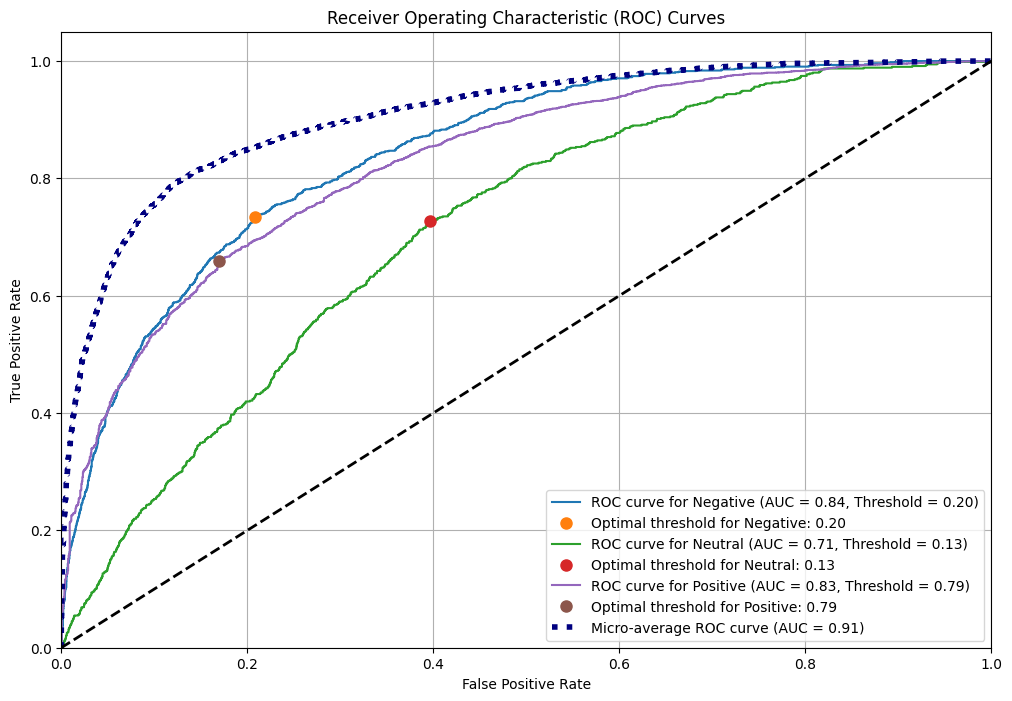


Optimal Thresholds for Each Class:
Negative: 0.2000
  - True Positive Rate (Sensitivity): 0.7341
  - False Positive Rate: 0.2081
  - Specificity: 0.7919

Neutral: 0.1287
  - True Positive Rate (Sensitivity): 0.7268
  - False Positive Rate: 0.3960
  - Specificity: 0.6040

Positive: 0.7927
  - True Positive Rate (Sensitivity): 0.6594
  - False Positive Rate: 0.1696
  - Specificity: 0.8304


Testing prediction with optimal thresholds:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Review: The hotel was fantastic with great service and amenities.
Predicted Sentiment: Positive
Probabilities: Negative: 0.0245, Neutral: 0.0388, Positive: 0.9366

Review: The room was okay but the staff could have been more helpful.
Predicted Sentiment: Neutral
Probabilities: Negative: 0.2475, Neutral: 0.2549, Positive: 0.4976

Review: Terrible experience, dirty rooms and rude staff.
Predicted Sentiment: Negative
Probabilities: Negative: 0.4914, Neutral: 0.2806, Positive: 0.2280



In [54]:
# After making predictions with your model:
y_pred_prob = model.predict(X_test)
y_test_classes = np.argmax(y_test, axis=1)

# Convert to binary class matrices for ROC
# Assuming your label_encoder.classes_ is ['Negative', 'Neutral', 'Positive']
class_names = label_encoder.classes_
n_classes = len(class_names)

# Binarize the test labels
y_test_bin = label_binarize(y_test_classes, classes=range(n_classes))

# Plot ROC curves
plt.figure(figsize=(12, 8))

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
thresholds = {}
roc_auc = {}
optimal_thresholds = {}

for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Find optimal threshold using Youden's J statistic (maximum of sensitivity + specificity - 1)
    j_scores = tpr[i] - fpr[i]
    optimal_idx = np.argmax(j_scores)
    optimal_thresholds[i] = thresholds[i][optimal_idx]
    
    plt.plot(
        fpr[i], tpr[i],
        label=f'ROC curve for {class_names[i]} (AUC = {roc_auc[i]:.2f}, '
              f'Threshold = {optimal_thresholds[i]:.2f})'
    )
    
    # Mark the optimal threshold point
    plt.plot(fpr[i][optimal_idx], tpr[i][optimal_idx], 'o', markersize=8,
             label=f'Optimal threshold for {class_names[i]}: {optimal_thresholds[i]:.2f}')

# Calculate micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thresholds["micro"] = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.plot(
    fpr["micro"], tpr["micro"],
    label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
    color='navy', linestyle=':', linewidth=4
)

# Plot diagonal line for random predictions
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot details
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)

plt.show()

# Print optimal thresholds with metrics
print("\nOptimal Thresholds for Each Class:")
for i in range(n_classes):
    optimal_idx = np.argmax(tpr[i] - fpr[i])
    print(f"{class_names[i]}: {optimal_thresholds[i]:.4f}")
    print(f"  - True Positive Rate (Sensitivity): {tpr[i][optimal_idx]:.4f}")
    print(f"  - False Positive Rate: {fpr[i][optimal_idx]:.4f}")
    print(f"  - Specificity: {1-fpr[i][optimal_idx]:.4f}")
    print()

# Apply optimal thresholds to make new predictions
def predict_with_optimal_thresholds(probabilities, thresholds):
    # For each sample, select the class with the highest probability/threshold ratio
    # This accounts for different optimal thresholds per class
    normalized_probs = np.zeros_like(probabilities)
    
    for i in range(n_classes):
        normalized_probs[:, i] = probabilities[:, i] / thresholds[i]
    
    return np.argmax(normalized_probs, axis=1)

# Use the new threshold-adjusted prediction function
y_pred_adjusted = predict_with_optimal_thresholds(y_pred_prob, 
                                                 [optimal_thresholds[i] for i in range(n_classes)])

# Convert predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred_adjusted)

# Update the predict_sentiment function to use optimal thresholds
def predict_sentiment_with_threshold(new_reviews, optimal_thresholds):
    # Process the reviews
    processed_reviews = []
    for review in new_reviews:
        _, processed = extract_words_with_pos(review)
        processed_reviews.append(processed)
    
    # Convert to one-hot encoding
    one_hot_reviews = [one_hot(words, voc_size) for words in processed_reviews]
    
    # Pad sequences
    padded_reviews = pad_sequences(one_hot_reviews, padding='pre', maxlen=sent_length)
    
    # Get raw probabilities
    predictions_prob = model.predict(padded_reviews)
    
    # Apply optimal thresholds
    predictions_adjusted = predict_with_optimal_thresholds(predictions_prob, 
                                                         [optimal_thresholds[i] for i in range(n_classes)])
    
    # Convert back to labels
    predicted_labels = label_encoder.inverse_transform(predictions_adjusted)
    
    return predicted_labels, predictions_prob

# Example usage with new thresholds
print("\nTesting prediction with optimal thresholds:")
sample_reviews = [
    "The hotel was fantastic with great service and amenities.",
    "The room was okay but the staff could have been more helpful.",
    "Terrible experience, dirty rooms and rude staff."
]

predictions, probabilities = predict_sentiment_with_threshold(sample_reviews, 
                                                           [optimal_thresholds[i] for i in range(n_classes)])

for i, (review, sentiment) in enumerate(zip(sample_reviews, predictions)):
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment}")
    print(f"Probabilities: Negative: {probabilities[i][0]:.4f}, Neutral: {probabilities[i][1]:.4f}, Positive: {probabilities[i][2]:.4f}")
    print()

In [55]:
model.save("hotel_sentiment_model.h5")
# Save label encoder
joblib.dump(label_encoder, "label_encoder.pkl")
print("Model and encoder saved successfully!")

Model and encoder saved successfully!
